In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## CRM determination

In [2]:
ndat = 10  # number of data points
sigma_exp = 1 # experimental uncertainty
C = sigma_exp ** 2 * np.diag(np.ones(ndat))
C_inverse = np.linalg.inv(C)
n_reps = 10000  # number of replicas
x_data = np.arange(1, 11, 1)

a_truth = 1
b_truth = 1
b_values = np.linspace(b_truth - 0.5, b_truth + 0.5, 5) # scan the chi2 along these offsets

def chi2_fit(a, y_data, fit_invcovmat, b_offset):
    # b_offset is fixed to 0.118 let's say (like alphas in NNPDF)
    # a are the parameters to be fitted, like the neural network weights in nnpdf
    theory = a * x_data + b_offset
    diff = y_data - theory
    chi2 = diff @ fit_invcovmat @ diff.T
    return chi2

chi2_values_scan = []
# generate n_reps replicas and minimise the chi2 with respect to a at each b value
for rep in range(n_reps):
    # closure data 
    y_data = a_truth * x_data + np.random.multivariate_normal(np.zeros(ndat), C, 1) + b_truth
    chi2_values_min = []
    for b_val in b_values:
        result = minimize(chi2_fit, [1], args=(y_data, C_inverse, b_val))
        chi2_values_min.append(result.fun)
    chi2_values_scan.append(chi2_values_min)
chi2_values_scan = np.array(chi2_values_scan) 

In [3]:
b_values_fitted = []
for chi2_values in chi2_values_scan:
    a, b, c = np.polyfit(b_values, chi2_values, 2)
    central = -b / 2 / a
    unc = np.sqrt(1/a/ndat)
    b_values_fitted.append(central)


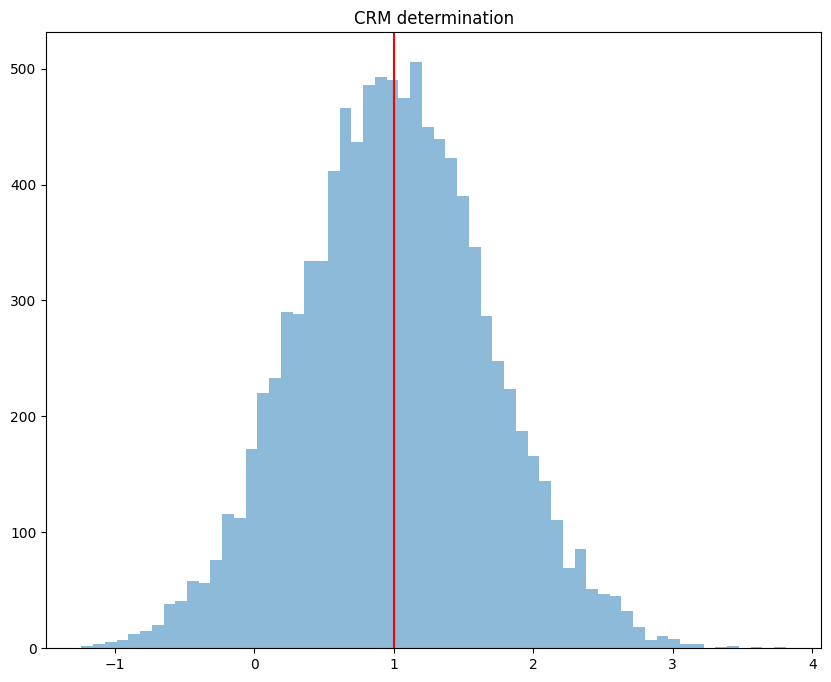

In [4]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.hist(b_values_fitted, bins='fd', ec='k', alpha=0.5)
ax.set_title("CRM determination")
ax.axvline(b_truth, color='r', label='central value')

In [5]:
mean_b_CRM = np.mean(b_values_fitted)
std_b_CRM = np.std(b_values_fitted)

print(f"CRM determination (68% CL): {mean_b_CRM} +/- {std_b_CRM}")

CRM determination (68% CL): 0.9993789148314001 +/- 0.679653870550964


## TCM determination

In [6]:
# Set the prior range
delta_b = 4
b_prior_central = b_truth - 0.1  # can be different from the true value b_truth
b_prior_plus = b_prior_central + delta_b
b_prior_min = b_prior_central - delta_b

a_prior = a_truth  # slope parameter, can be different from the true value a_truth

# and the prior theory predictions
prior_theorypreds_plus = b_prior_plus + a_prior * x_data
prior_theorypreds_central = b_prior_central + a_prior * x_data
prior_theorypreds_minus = b_prior_min + a_prior * x_data

delta_plus = 1/ np.sqrt(2) * (prior_theorypreds_plus - prior_theorypreds_central)
delta_minus = 1 / np.sqrt(2) * (prior_theorypreds_minus - prior_theorypreds_central)

beta = np.array([delta_plus, delta_minus]).T  # shape (n_dat, 2 * n_par)
S = beta @ beta.T

invcov = np.linalg.inv(C + S)

In [7]:
# prior
step_size = np.abs(b_prior_plus - b_prior_central)
beta_tilde = step_size / np.sqrt(2) * np.array([[1, -1]])
S_tilde = beta_tilde @ beta_tilde.T
S_hat = beta_tilde @ beta.T


In [8]:
y_theory_tcm = []
y_data_tcm = []
for rep in range(100 * n_reps):
    y_data = a_truth * x_data + np.random.multivariate_normal(np.zeros(ndat), C + S, 1) + b_truth
    result = minimize(chi2_fit, [1], args=(y_data, invcov, b_prior_central))
    
    y_theory_tcm.append(result.x[0] * x_data + b_prior_central)
    y_data_tcm.append(y_data.flatten())
    
y_theory_tcm = np.array(y_theory_tcm)
y_data_tcm = np.array(y_data_tcm)
X = np.cov(y_theory_tcm.T)

In [9]:
P_tilde = S_hat @ invcov @ X @ invcov @ S_hat.T + S_tilde - S_hat @ invcov @ S_hat.T
delta_T_tilde = -S_hat @ invcov @ (y_theory_tcm.mean(axis=0) - y_data_tcm.mean(axis=0))
T_tilde = b_prior_central + delta_T_tilde

print(f"TCM determination (68%): {T_tilde[0]} +/- {np.sqrt(P_tilde[0,0])}")
print(f"CRM determination (68%): {mean_b_CRM} +/- {std_b_CRM}")

TCM determination (68%): 0.9932608007881072 +/- 0.6739584494376193
CRM determination (68%): 0.9993789148314001 +/- 0.679653870550964


In [10]:
print("Uncertainty due to replicas: ", S_hat @ invcov @ X @ invcov @ S_hat.T)
print("Uncertainty prior: ", S_tilde)
print("Uncertainty reduction by data: ", S_hat @ invcov @ S_hat.T)

Uncertainty due to replicas:  [[0.35484111]]
Uncertainty prior:  [[16.]]
Uncertainty reduction by data:  [[15.90062112]]


In [11]:
np.sqrt(S_hat @ invcov @ X @ invcov @ S_hat.T / P_tilde)

array([[0.88386074]])

In [12]:
S_hat @ invcov @ (X @ invcov - np.eye(ndat)) @ S_hat.T + S_tilde 

array([[0.45421999]])